# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

training_values = pd.read_csv("/content/drive/My Drive/Colab Notebooks/UWS/water_table/training_set_values.csv")
training_labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/UWS/water_table/training_set_labels.csv")

waterpoints = pd.concat([training_values, training_labels['status_group']], axis=1)

waterpoints.head()

Mounted at /content/drive


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Exploring the data

### Looking at the features

We use the pandas function df.describe() to obtain the mean and the standard deviation. It will also show us the numerical features in the dataset

In [ ]:
waterpoints.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


However we need to consider that the numerical features that we found are not necessarly real numerical/physical attributes. Indeed, some features are quantitative and other are qualitative.

We need to reduce the number of numerical features to consider. Here, we will consider numerical features as ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

In [ ]:
numerical_features_reduced = ['amount_tsh', 'gps_height', 'longitude', 
                              'latitude', 'population', 'construction_year']

waterpoints_num = waterpoints[numerical_features_reduced]

waterpoints_num.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,30500.000000,2013.000000


We will now look at the 5 most repeated values

In [ ]:
for column in waterpoints.columns:
  if (column != 'id'):
    print("the 5 most repeated values of", column, "are:")
    print(waterpoints[column].value_counts().head(), '\n')

the 5 most repeated values of amount_tsh are:
0.0       41639
500.0      3102
50.0       2472
1000.0     1488
20.0       1463
Name: amount_tsh, dtype: int64 

the 5 most repeated values of date_recorded are:
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
Name: date_recorded, dtype: int64 

the 5 most repeated values of funder are:
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Name: funder, dtype: int64 

the 5 most repeated values of gps_height are:
 0     20438
-15       60
-16       55
-13       55
-20       52
Name: gps_height, dtype: int64 

the 5 most repeated values of installer are:
DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
Name: installer, dtype: int64 

the 5 most repeated values of longitude are:
0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32

In [ ]:
# numerical_features = [column for column in df.columns if (df[column].dtype == float) or (df[column].dtype==int)]
categorical_features = []
numerical_features = []

for column in waterpoints.columns:
  if (waterpoints[column].dtype == int) or (waterpoints[column].dtype == float):
    numerical_features.append(column)
  else:
    categorical_features.append(column)
     
print(numerical_features)
print(categorical_features)

['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


### Numerical features

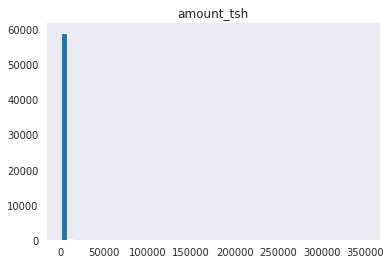

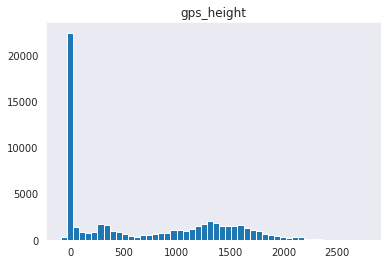

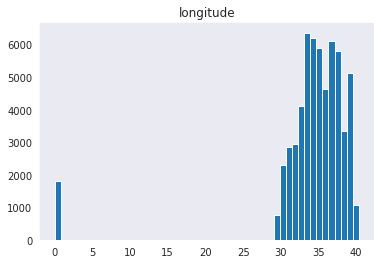

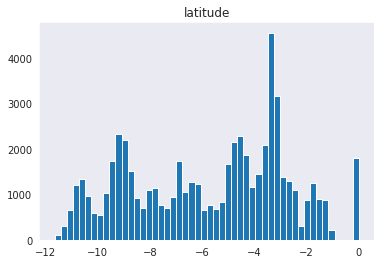

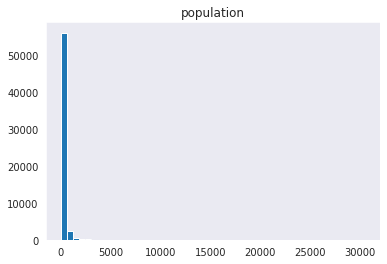

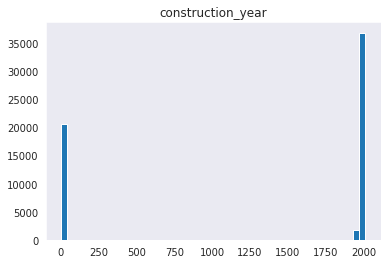

In [ ]:
for column in numerical_features_reduced:
  plt.hist(waterpoints[column], bins=50)
  plt.title(column)
  plt.show()

From the histograms, we can see that:
  - construction_year has a lot of irregular data
  - population has an outlier 
  - longitude has an outlier
  - amount_tsh has an outlier 

Indeed, the X-axis of the histogram shows us when we have a wide range of values and we don't see a lot of occurences of in the Y-axis. 

So there are few points that are far away from the other records.

Another way to see outliers is to use boxplots:

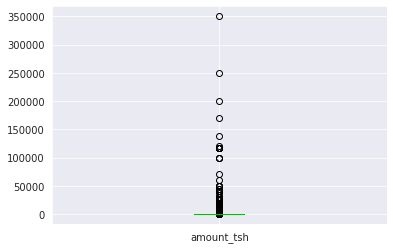

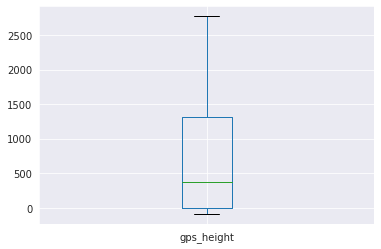

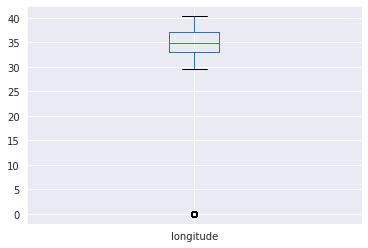

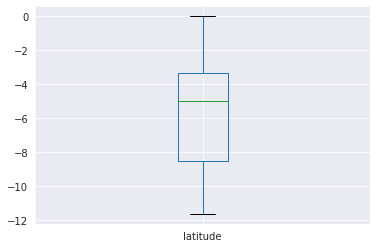

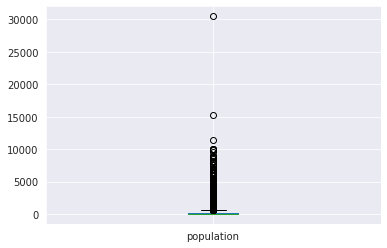

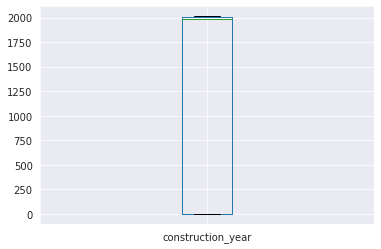

In [ ]:
for column in numerical_features_reduced:
  waterpoints.boxplot(column=[column])
  plt.show()

#### date_recorded

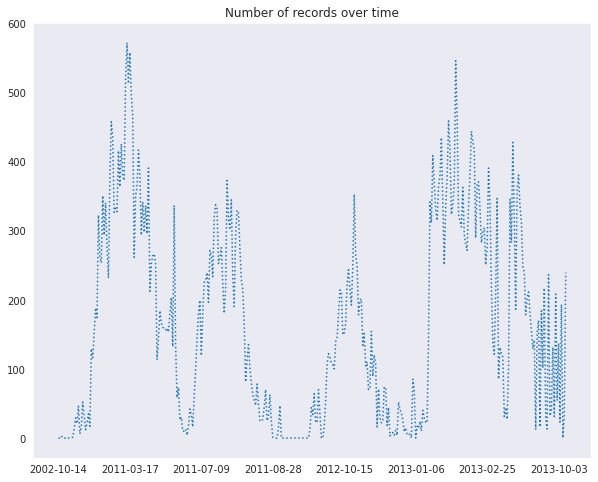

In [ ]:
waterpoints['date_recorded'].value_counts().sort_index().plot(kind='line', 
                                                            linestyle='dotted', 
                                                            figsize=(10,8), 
                                                            title='Number of records over time')

In [ ]:
months = pd.to_datetime(waterpoints['date_recorded']).dt.month
years = pd.to_datetime(waterpoints['date_recorded']).dt.year

# We can use df.assign() here because months, years and waterpoints have the same order in the rows...
# However there are other ways to do that  
df_with_month = waterpoints.assign(month = months)
df_with_month_year = df_with_month.assign(year = years) 

In [ ]:
years = pd.to_datetime(waterpoints['date_recorded']).dt.year

years.unique()

array([2011, 2013, 2012, 2004, 2002])

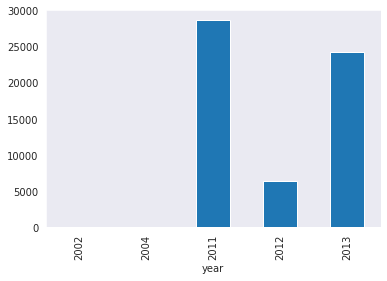

In [ ]:
df_with_month_year.groupby('year').count().id.plot(kind='bar')

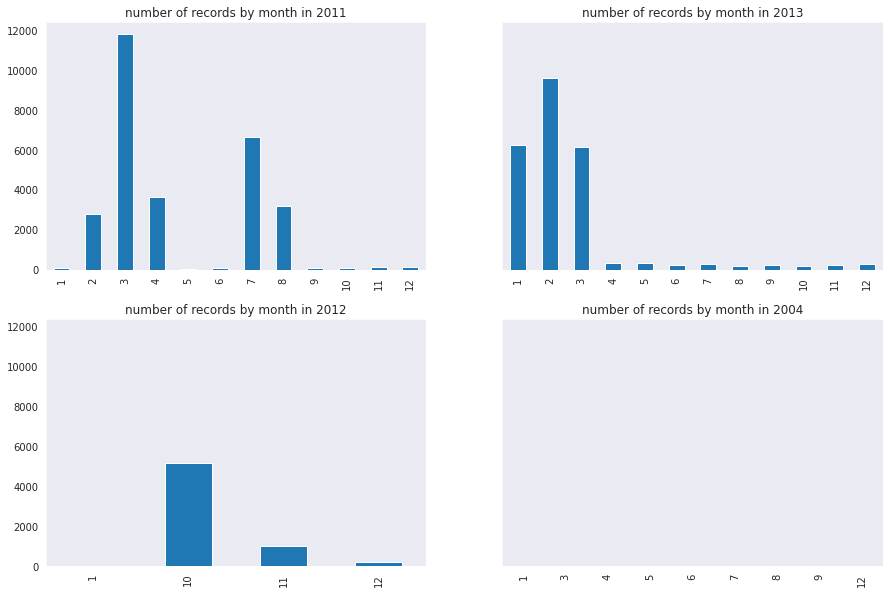

In [ ]:
df_to_print = [df_with_month_year[df_with_month_year.year == year]['month'].value_counts().sort_index() for year in years.unique()]
count=0
fig, axes = plt.subplots(2,2, sharey=True, figsize=(15,10))
for r in range(2):
    for c in range(2):
      title = "number of records by month in " + str(years.unique()[count])
      df_to_print[count].plot(kind='bar', title=title, sort_columns=True, ax=axes[r,c])
      count+=1


#### recorded_by

In [ ]:
waterpoints['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

Well... we see that all our rows (sliced dataset) have the value 'GeoData Consultants Ltd' for the feature 'recorded_by'

#### construction year

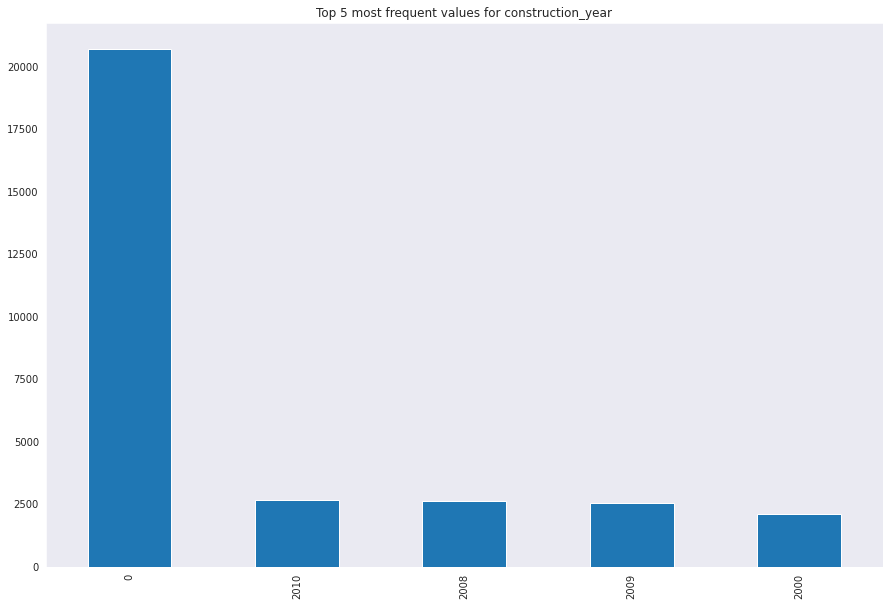

In [ ]:
# print(waterpoints['construction_year'].value_counts())

waterpoints['construction_year'].value_counts().head().plot(kind='bar', figsize=(15,10), title='Top 5 most frequent values for construction_year')

We see that there is a lot zero values for the construction year... I think we need to clean them or drop the specific rows 

#### funder

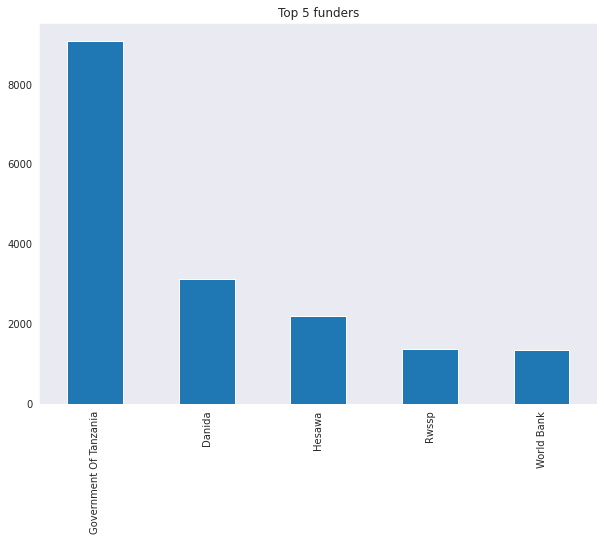

In [ ]:
waterpoints['funder'].value_counts().head().plot(kind='bar', figsize=(10,7), title='Top 5 funders')

### Categorical features

#### installer

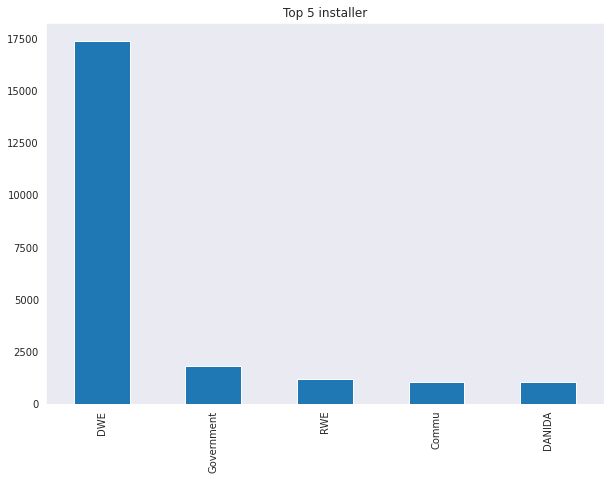

In [ ]:
waterpoints['installer'].value_counts().head().plot(kind='bar', figsize=(10,7), title='Top 5 installer')

#### extraction_type

There are 3 features: 
- 'extraction_type'
- 'extraction_type_group'
- 'extraction_type_class'

The question is whether or not we have redundant columns here...

In [ ]:
comparison_column = np.where(waterpoints["extraction_type"] == waterpoints["extraction_type_group"], True, False)

comparison_column.sum()

56931

In [ ]:
comparison_column = np.where(waterpoints["extraction_type_class"] == waterpoints["extraction_type_group"], True, False)

comparison_column.sum()

39957

In [ ]:
waterpoints['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [ ]:
waterpoints['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [ ]:
waterpoints['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

As we can see, the 3 columns are not identifical. They do share common values but they also have different values 

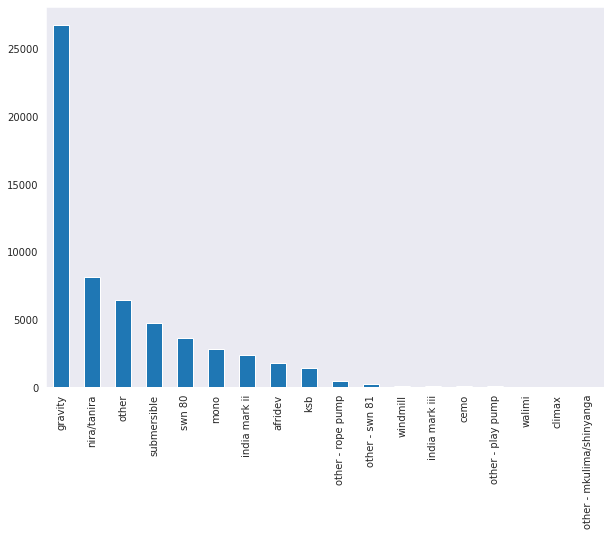

In [ ]:
waterpoints['extraction_type'].value_counts().plot(kind='bar', figsize=(10, 7))

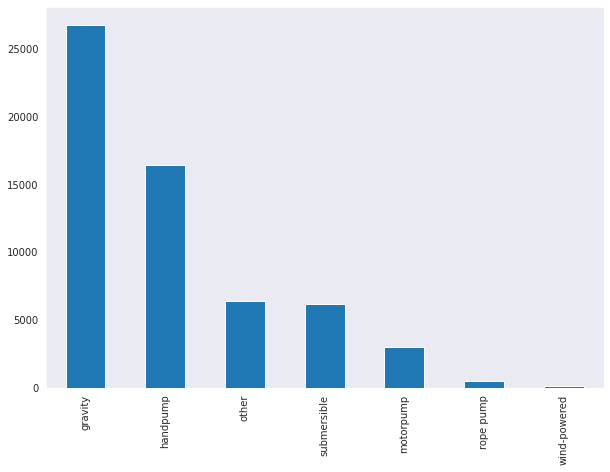

In [ ]:
waterpoints['extraction_type_class'].value_counts().plot(kind='bar', figsize=(10, 7))

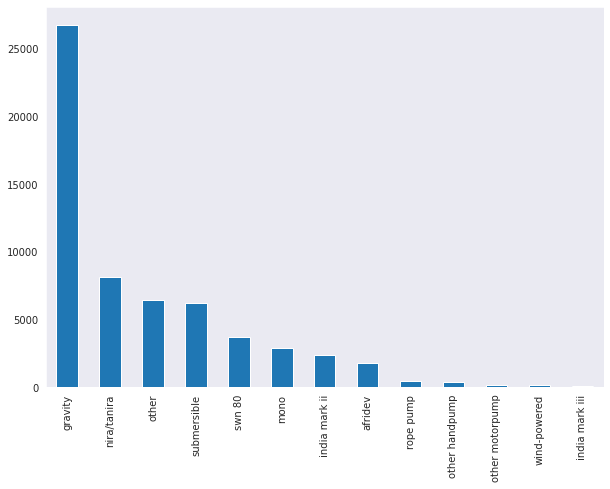

In [ ]:
waterpoints['extraction_type_group'].value_counts().plot(kind='bar', figsize=(10, 7))

#### waterpoint_type

In [ ]:
waterpoints['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

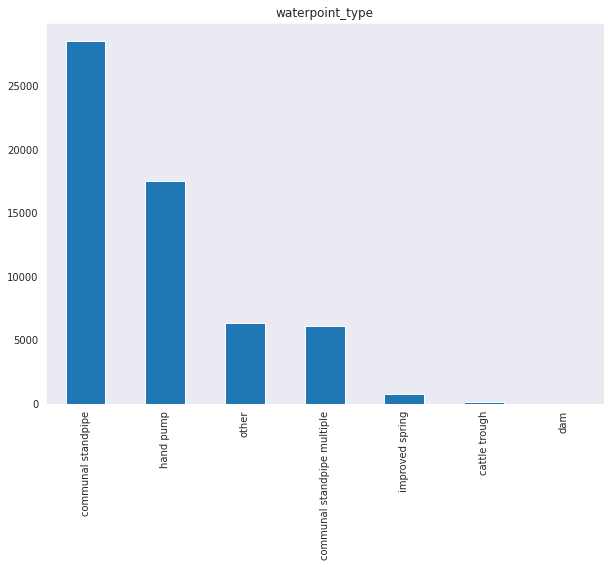

In [ ]:
waterpoints['waterpoint_type'].value_counts().plot(kind='bar', figsize=(10, 7), title='waterpoint_type')

In [ ]:
waterpoints['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

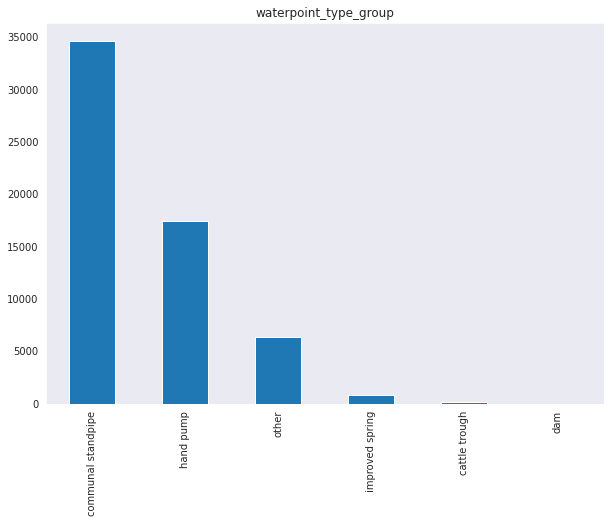

In [ ]:
waterpoints['waterpoint_type_group'].value_counts().plot(kind='bar', figsize=(10, 7), title='waterpoint_type_group')

#### source

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64


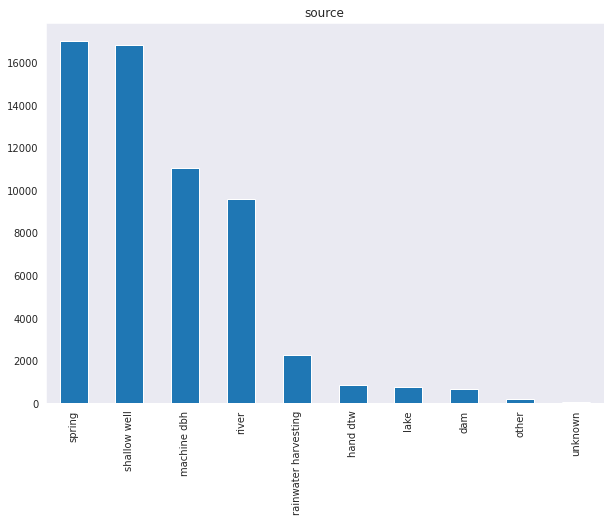

In [ ]:
print(waterpoints['source'].value_counts())

waterpoints['source'].value_counts().plot(kind='bar', title='source', figsize=(10,7))

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


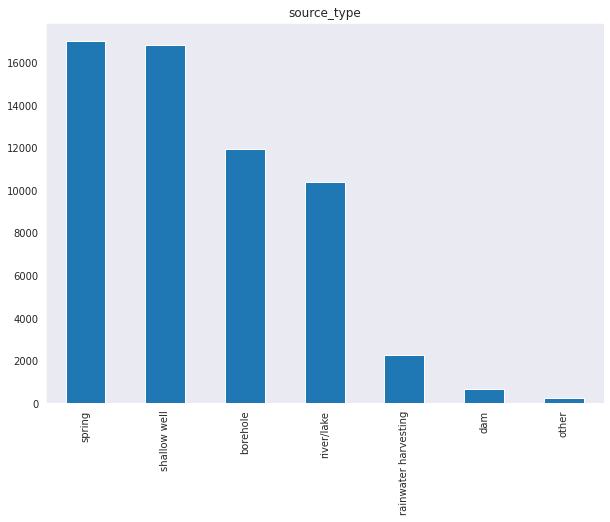

In [ ]:
print(waterpoints['source_type'].value_counts())

waterpoints['source_type'].value_counts().plot(kind='bar', title='source_type', figsize=(10,7))

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


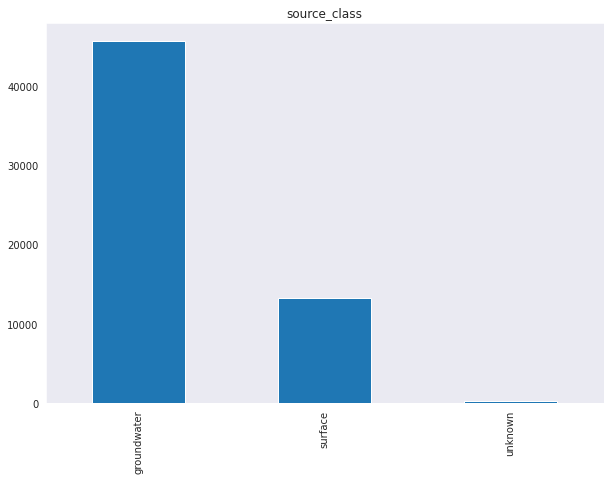

In [ ]:
print(waterpoints['source_class'].value_counts())

waterpoints['source_class'].value_counts().plot(kind='bar', title='source_class', figsize=(10,7))

#### quantity

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64


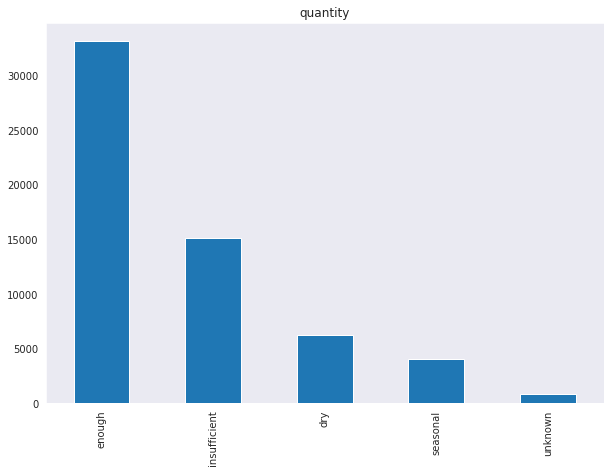

In [ ]:
print(waterpoints['quantity'].value_counts())

waterpoints['quantity'].value_counts().plot(kind='bar', title='quantity', figsize=(10,7))

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


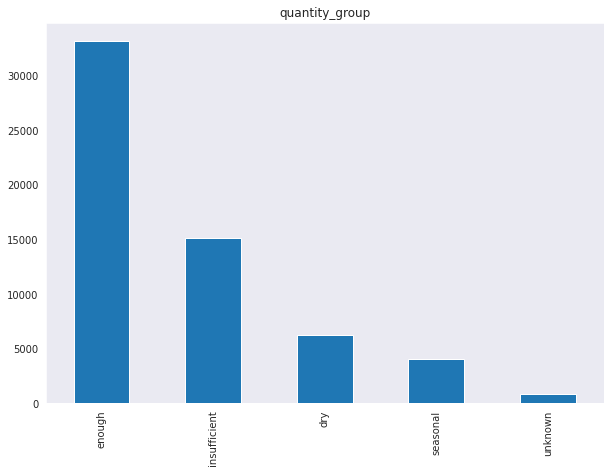

In [ ]:
print(waterpoints['quantity_group'].value_counts())

waterpoints['quantity_group'].value_counts().plot(kind='bar', title='quantity_group', figsize=(10,7))

#### the quality of the water (water_quality, quality_group)

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64


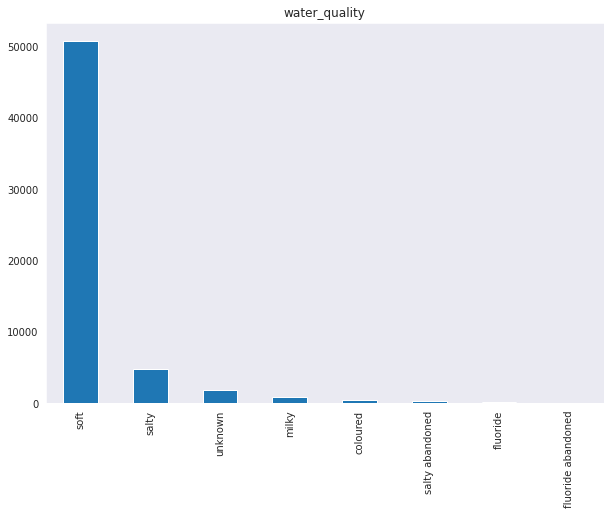

In [ ]:
print(waterpoints['water_quality'].value_counts())

waterpoints['water_quality'].value_counts().plot(kind='bar', title='water_quality', figsize=(10,7))

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


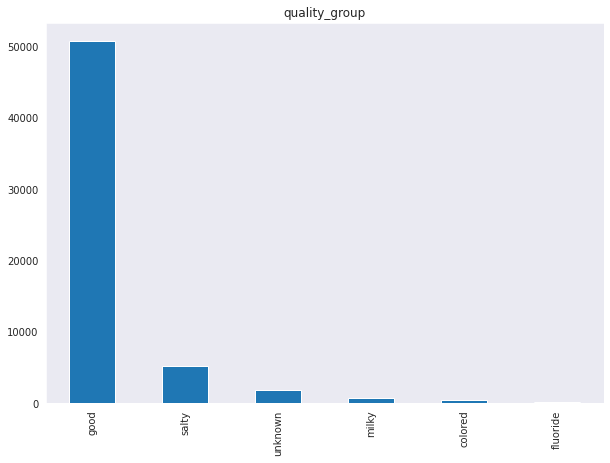

In [ ]:
print(waterpoints['quality_group'].value_counts())

waterpoints['quality_group'].value_counts().plot(kind='bar', title='quality_group', figsize=(10,7))

#### what the water costs (payment, payment_type)

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64


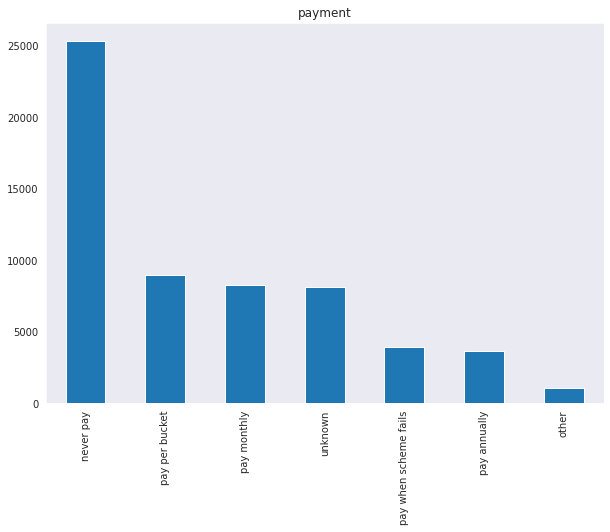

In [ ]:
print(waterpoints['payment'].value_counts())

waterpoints['payment'].value_counts().plot(kind='bar', title='payment', figsize=(10,7))

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


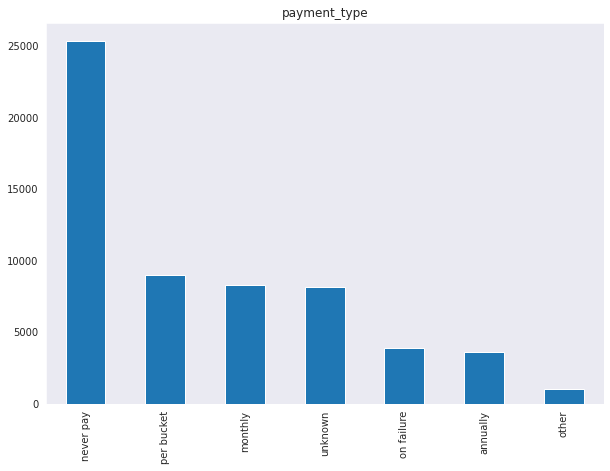

In [ ]:
print(waterpoints['payment_type'].value_counts())

waterpoints['payment_type'].value_counts().plot(kind='bar', title='payment_type', figsize=(10,7))

#### how the waterpoint is managed (management, management_group)

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64


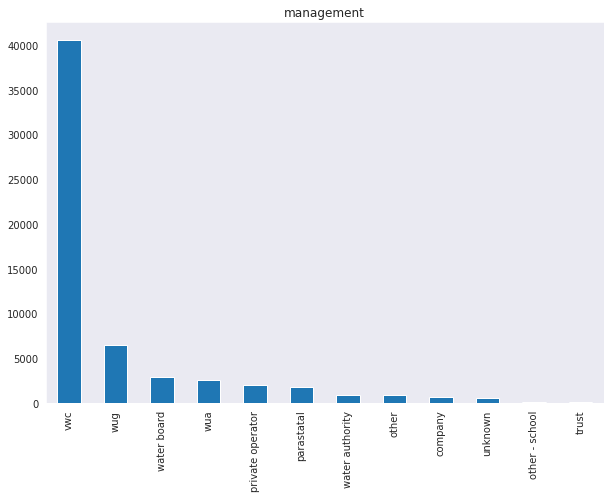

In [ ]:
print(waterpoints['management'].value_counts())

waterpoints['management'].value_counts().plot(kind='bar', title='management', figsize=(10,7))

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


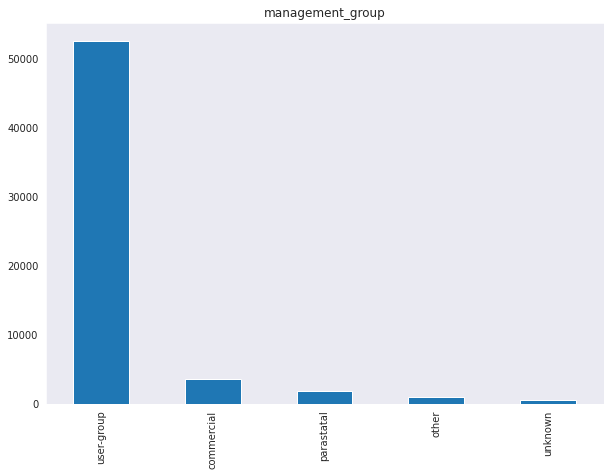

In [ ]:
print(waterpoints['management_group'].value_counts())

waterpoints['management_group'].value_counts().plot(kind='bar', title='management_group', figsize=(10,7))

### geographic locations (subvillage, region, region_code, district_code, basin)

In [ ]:
waterpoints['subvillage'].value_counts()

Madukani         508
Shuleni          506
Majengo          502
Kati             373
Mtakuja          262
                ... 
Kyongwa Chini      1
Mdori              1
Talaga             1
Butibu A           1
Keisunguruta       1
Name: subvillage, Length: 19287, dtype: int64

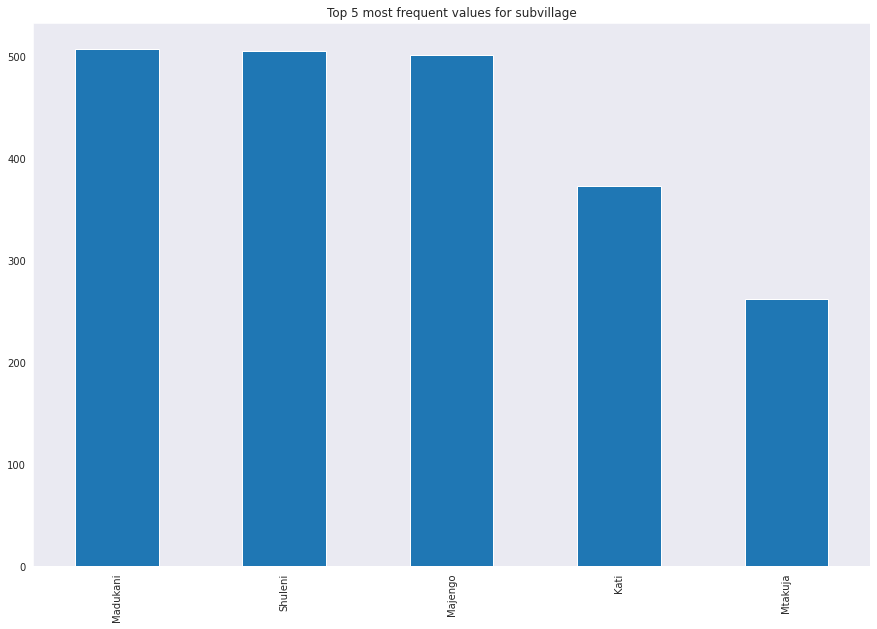

In [ ]:
waterpoints['subvillage'].value_counts().head().plot(kind='bar', figsize=(15,10), title='Top 5 most frequent values for subvillage')

In [ ]:
waterpoints['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

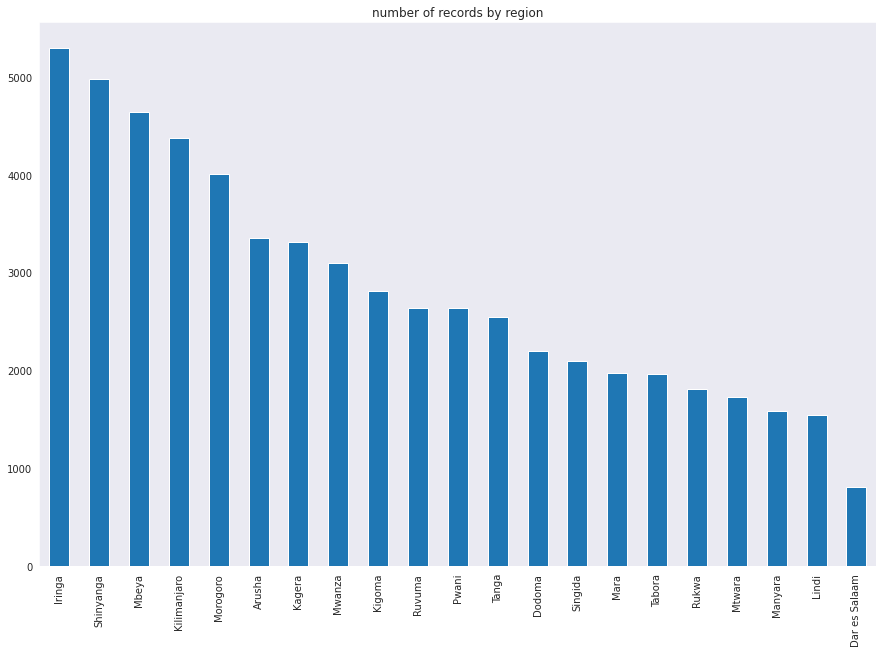

In [ ]:
waterpoints['region'].value_counts().plot(kind='bar', figsize=(15,10), title='number of records by region')

In [ ]:
waterpoints['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

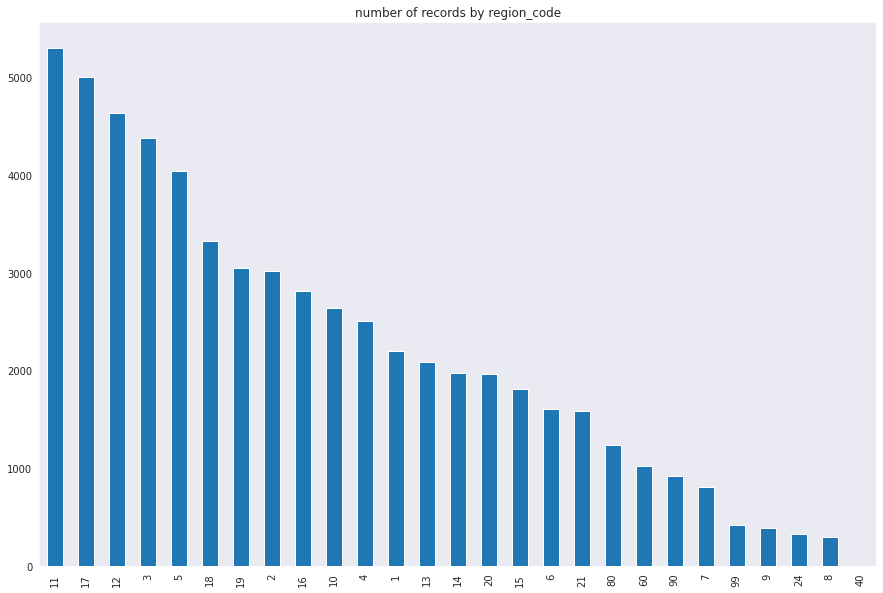

In [ ]:
waterpoints['region_code'].value_counts().plot(kind='bar', figsize=(15,10), title='number of records by region_code')

In [ ]:
waterpoints['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

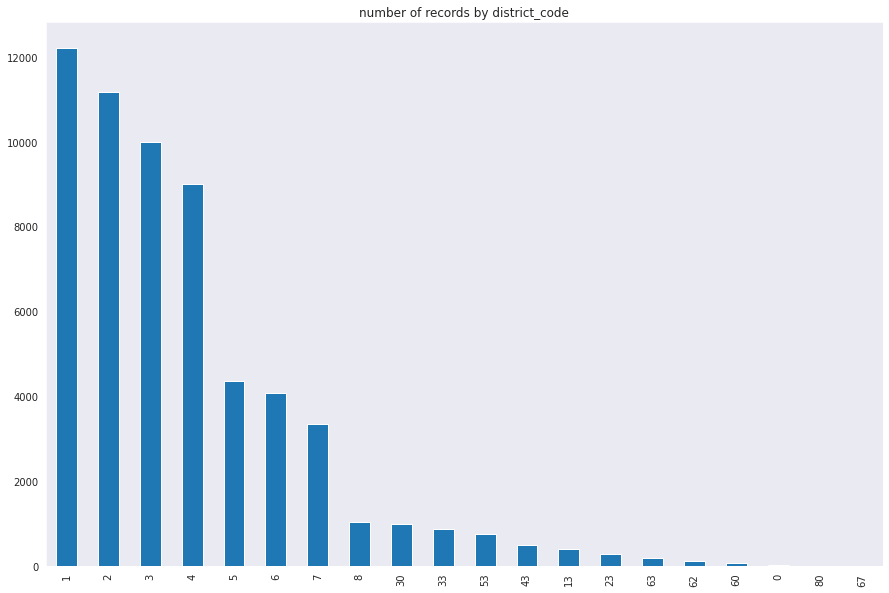

In [ ]:
waterpoints['district_code'].value_counts().plot(kind='bar', figsize=(15,10), title='number of records by district_code')

In [ ]:
waterpoints['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

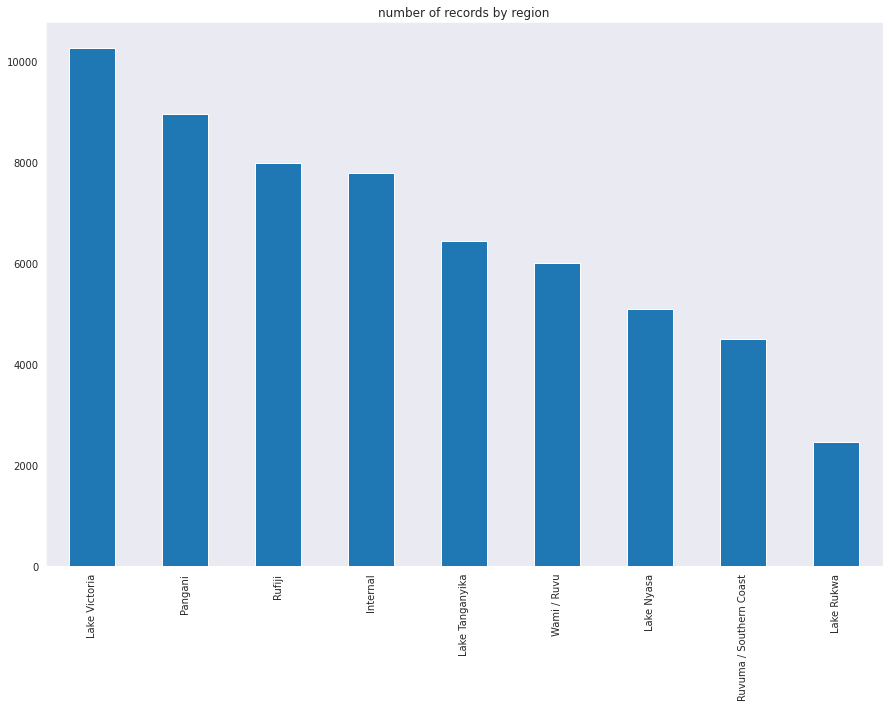

In [ ]:
waterpoints['basin'].value_counts().plot(kind='bar', figsize=(15,10), title='number of records by region')

### Geographical data (longtitude, latitude, population)

We have two interesting geographical attributes: longitude and latitude

Hence we can try to plot the waterpoints on a map of the country

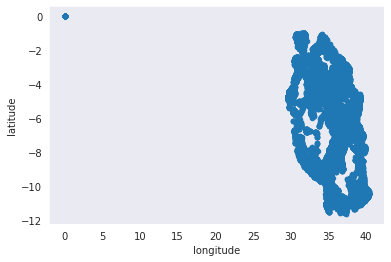

In [ ]:
waterpoints.plot(kind='scatter', x='longitude', y='latitude')

There is a clear outlier in the 'longitude' and 'latitude' features. 

For the moment, we will just drop this row in order to vizualize our geographical data correctly

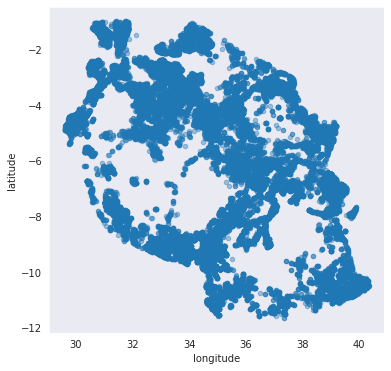

In [ ]:
longitude = waterpoints['longitude'][waterpoints['longitude'] != 0]

geo_df = waterpoints[(waterpoints.longitude!=0)]

geo_df.longitude.sort_values()
geo_df.plot(kind='scatter', x='longitude', y='latitude',
            alpha=0.4, figsize=(6,6))
plt.show()

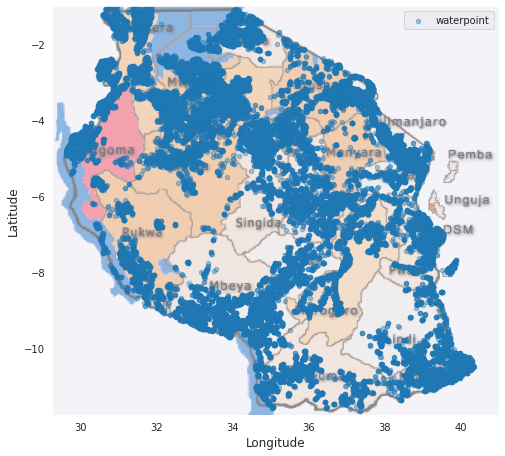

In [ ]:
import matplotlib.image as mpimg

tanzania_img = mpimg.imread("/content/drive/My Drive/Colab Notebooks/UWS/water_table/map_tanzania.png")

ax = geo_df.plot(kind='scatter', 
            x='longitude', y='latitude', alpha=0.4, label='waterpoint', 
            figsize=(8,8), cmap=plt.get_cmap("jet"))

plt.imshow(tanzania_img, extent=[29.25, 41, -11.75, -1], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel('Latitude', fontsize=12)
plt.xlabel('Longitude', fontsize=12)

plt.legend()

We can try to observe the population around each waterpoint on the map

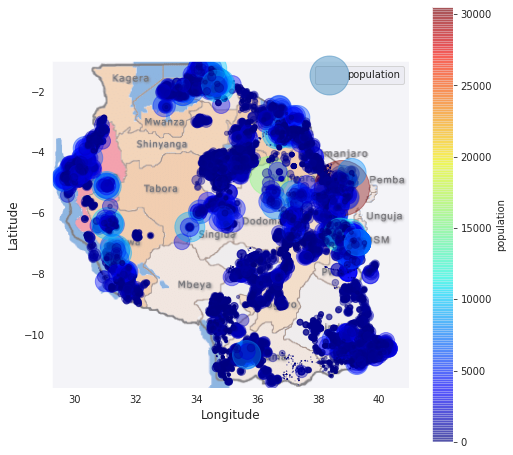

In [ ]:
import matplotlib.image as mpimg

tanzania_img = mpimg.imread("/content/drive/My Drive/Colab Notebooks/UWS/water_table/map_tanzania.png")

ax = geo_df.plot(kind='scatter', 
            x='longitude', y='latitude', alpha=0.4, label='population', 
            s= geo_df['population'].apply(lambda x: x /10), c="population",
            figsize=(8,8), cmap=plt.get_cmap("jet"), colorbar = True, sharex=False)

plt.imshow(tanzania_img, extent=[29.25, 41, -11.75, -1], alpha=0.5,
           cmap=plt.get_cmap("jet"))

plt.ylabel('Latitude', fontsize=12)
plt.xlabel('Longitude', fontsize=12)

plt.legend()

# Create Test-Train Sets

In [ ]:
train_set, test_set = train_test_split(waterpoints, test_size=0.2, random_state=42)

In [ ]:
train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
3607,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
50870,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
20413,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52806,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
50091,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


# Feature Selection

In [ ]:
categorical_features = []
numerical_features = []

for column in waterpoints.columns:
  if (waterpoints[column].dtype == int) or (waterpoints[column].dtype == float):
    numerical_features.append(column)
  else:
    categorical_features.append(column)
     
print(numerical_features)
print(categorical_features)

['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [ ]:
numerical_features_selected = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

categorical_features_selected = ['basin', 'permit', 'public_meeting', 'scheme_management', 
                   'extraction_type_class', 'management_group', 'payment',
                   'quality_group', 'quantity_group', 'source_class',
                   'source_type', 'waterpoint_type_group', 'status_group']

selected_features = numerical_features_selected + categorical_features_selected

In [ ]:
train_set = train_set[selected_features]

train_set.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,basin,permit,public_meeting,scheme_management,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,source_type,waterpoint_type_group,status_group
3607,50.0,2092,35.426020,-4.227446,160,1998,Internal,True,True,Water Board,gravity,user-group,pay per bucket,good,insufficient,groundwater,spring,communal standpipe,functional
50870,0.0,0,35.510074,-5.724555,0,0,Internal,True,True,VWC,handpump,user-group,never pay,good,enough,groundwater,shallow well,hand pump,functional
20413,0.0,0,32.499866,-9.081222,0,0,Lake Rukwa,False,True,VWC,other,user-group,never pay,good,enough,groundwater,shallow well,other,non functional
52806,0.0,0,34.060484,-8.830208,0,0,Rufiji,True,True,VWC,gravity,user-group,pay monthly,good,insufficient,surface,river/lake,communal standpipe,non functional
50091,300.0,1023,37.032690,-6.040787,120,1997,Wami / Ruvu,True,True,VWC,other,user-group,pay when scheme fails,salty,enough,groundwater,shallow well,other,non functional


# Data cleaning

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             47520 non-null  float64
 1   gps_height             47520 non-null  int64  
 2   longitude              47520 non-null  float64
 3   latitude               47520 non-null  float64
 4   population             47520 non-null  int64  
 5   construction_year      47520 non-null  int64  
 6   basin                  47520 non-null  object 
 7   permit                 45081 non-null  object 
 8   public_meeting         44831 non-null  object 
 9   scheme_management      44418 non-null  object 
 10  extraction_type_class  47520 non-null  object 
 11  management_group       47520 non-null  object 
 12  payment                47520 non-null  object 
 13  quality_group          47520 non-null  object 
 14  quantity_group         47520 non-null  object 
 15 

## Numerical Features

### Detection of outliers and handling them

In [ ]:
train_set.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000
mean,322.047573,668.745370,34.091316,-5.705002e+00,179.528283,1303.353199
std,3200.623244,692.972153,6.538403,2.943503e+00,472.772997,950.763878
min,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,33.084320,-8.532465e+00,0.000000,0.000000
50%,0.000000,370.000000,34.911677,-5.017697e+00,25.000000,1986.000000
75%,20.000000,1320.000000,37.180585,-3.326464e+00,213.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,30500.000000,2013.000000


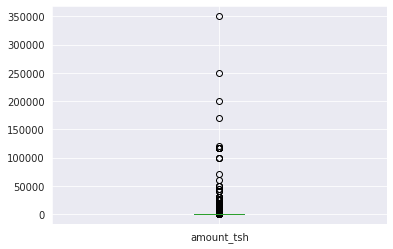

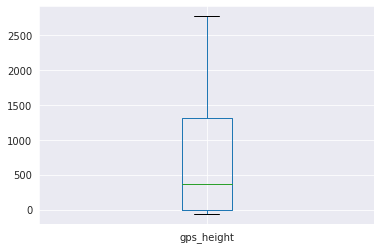

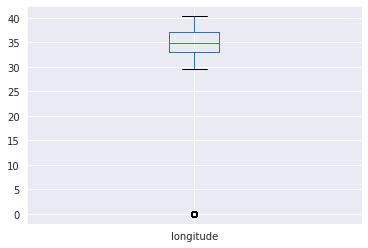

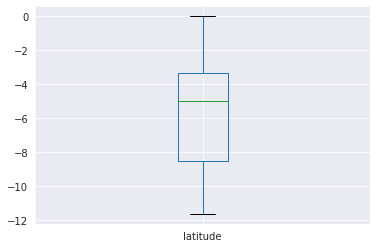

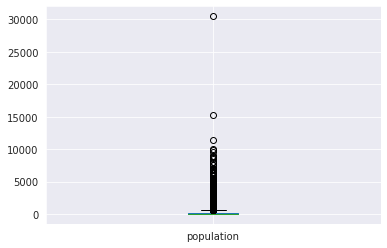

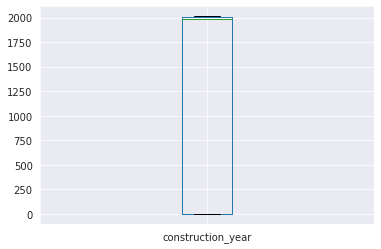

In [ ]:
for column in numerical_features_selected:
  train_set.boxplot(column=[column])
  plt.show()

#### We drop null values for 'longitude' feature

In [ ]:
train_set = train_set[train_set['longitude'] != 0]

In [ ]:
train_set.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,46087.000000,46087.000000,46087.000000,46087.000000,46087.000000,46087.000000
mean,332.061116,689.538916,35.151330,-5.882390,185.110422,1343.878838
std,3249.490882,693.400186,2.611187,2.808937,478.989494,936.801335
min,0.000000,-63.000000,29.607122,-11.649440,0.000000,0.000000
25%,0.000000,0.000000,33.275077,-8.633477,0.000000,0.000000
50%,0.000000,426.000000,35.010620,-5.164521,35.000000,1988.000000
75%,30.000000,1332.000000,37.238584,-3.372232,230.000000,2005.000000
max,350000.000000,2770.000000,40.345193,-0.998464,30500.000000,2013.000000


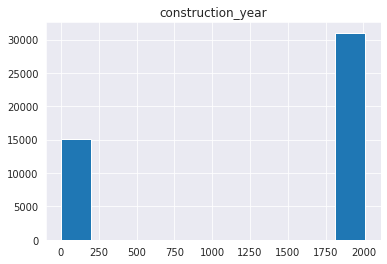

In [ ]:
train_set.hist(column='construction_year')
plt.show()

In [ ]:
train_set[train_set['construction_year'] != 0].describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,31017.000000,31017.000000,31017.000000,31017.000000,31017.000000,31017.000000
mean,471.927119,1000.637876,35.984869,-6.236094,268.818229,1996.819293
std,3773.882589,618.405646,2.561355,2.760324,553.541669,12.481234
min,0.000000,-63.000000,29.607122,-11.649440,0.000000,1960.000000
25%,0.000000,370.000000,34.674601,-8.753766,30.000000,1987.000000
50%,0.000000,1152.000000,36.650394,-6.078033,150.000000,2000.000000
75%,200.000000,1485.000000,37.811420,-3.653940,300.000000,2008.000000
max,350000.000000,2770.000000,40.345193,-1.052271,30500.000000,2013.000000


In [ ]:
construction_year_mean = train_set[train_set['construction_year'] != 0].mean()['construction_year']

construction_year_mean

1996.8192926459683

In [ ]:
train_set['construction_year'] = train_set['construction_year'].replace(0, construction_year_mean)

train_set.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,46087.000000,46087.000000,46087.000000,46087.000000,46087.000000,46087.000000
mean,332.061116,689.538916,35.151330,-5.882390,185.110422,1996.819293
std,3249.490882,693.400186,2.611187,2.808937,478.989494,10.239198
min,0.000000,-63.000000,29.607122,-11.649440,0.000000,1960.000000
25%,0.000000,0.000000,33.275077,-8.633477,0.000000,1995.000000
50%,0.000000,426.000000,35.010620,-5.164521,35.000000,1996.819293
75%,30.000000,1332.000000,37.238584,-3.372232,230.000000,2005.000000
max,350000.000000,2770.000000,40.345193,-0.998464,30500.000000,2013.000000


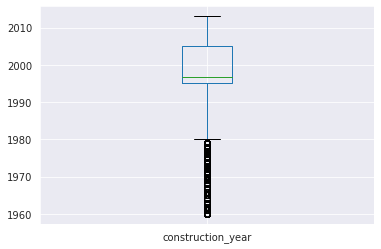

In [ ]:
train_set.boxplot(column='construction_year')
plt.show()

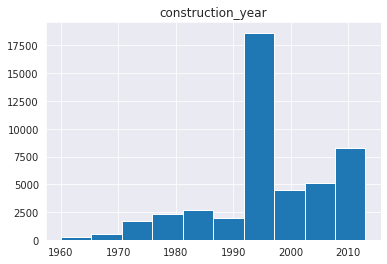

In [ ]:
train_set.hist(column='construction_year')
plt.show()

### Scaling data

In [ ]:
train_set_num = train_set[numerical_features_selected]

rbscaler = RobustScaler()

rbscaler.fit_transform(train_set_num)

array([[ 1.66666667,  1.25075075,  0.1048063 ,  0.17810904,  0.54347826,
         0.11807074],
       [ 0.        , -0.31981982,  0.12601308, -0.10644506, -0.15217391,
         0.        ],
       [ 0.        , -0.31981982, -0.6334676 , -0.74444362, -0.15217391,
         0.        ],
       ...,
       [ 0.        , -0.32957958,  1.00007263, -0.048715  ,  4.19565217,
         0.81807074],
       [ 0.        , -0.31981982, -0.17510591,  0.39104049, -0.15217391,
         0.        ],
       [ 0.        ,  0.64864865,  0.65996613,  0.37121702, -0.14782609,
        -2.08192926]])

## Categorical Features

### LabelEncoding (target variable 'status_group')

In [ ]:
train_set['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [ ]:
le = LabelEncoder()

le.fit(['non functional', 'functional needs repair', 'functional'])

le.transform(train_set['status_group'])

train_set['status_group'] = le.transform(train_set['status_group'])

In [ ]:
train_set.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,basin,permit,public_meeting,scheme_management,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,source_type,waterpoint_type_group,status_group
3607,50.0,2092,35.426020,-4.227446,160,1998.000000,Internal,True,True,Water Board,gravity,user-group,pay per bucket,good,insufficient,groundwater,spring,communal standpipe,0
50870,0.0,0,35.510074,-5.724555,0,1996.819293,Internal,True,True,VWC,handpump,user-group,never pay,good,enough,groundwater,shallow well,hand pump,0
20413,0.0,0,32.499866,-9.081222,0,1996.819293,Lake Rukwa,False,True,VWC,other,user-group,never pay,good,enough,groundwater,shallow well,other,2
52806,0.0,0,34.060484,-8.830208,0,1996.819293,Rufiji,True,True,VWC,gravity,user-group,pay monthly,good,insufficient,surface,river/lake,communal standpipe,2
50091,300.0,1023,37.032690,-6.040787,120,1997.000000,Wami / Ruvu,True,True,VWC,other,user-group,pay when scheme fails,salty,enough,groundwater,shallow well,other,2


### Fill NaN value with the mode

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')

columns = ['basin', 'permit', 'public_meeting', 'scheme_management', 
                   'extraction_type_class', 'management_group', 'payment',
                  'source_class','source_type', 'waterpoint_type_group']

train_set[columns] = imp.fit_transform(train_set[columns])

### OneHotEncoding

In [ ]:
onehot = OneHotEncoder(dtype=np.int, sparse=True)

ohe = onehot.fit_transform(train_set[columns]).toarray()

categorical_onehot = pd.DataFrame(ohe)

categorical_onehot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


## Creating a pipeline

In [ ]:
copy_train_set, copy_test_set = train_test_split(waterpoints, test_size=0.2, random_state=42)

columns_1hot = ['basin', 'permit', 'public_meeting', 'scheme_management', 
                   'extraction_type_class', 'management_group', 'payment', 'source_class',
                   'source_type', 'waterpoint_type_group']

columns_impute = ['permit', 'scheme_management', 'extraction_type_class', 'public_meeting']

combine = [copy_train_set, copy_test_set]

num_pipeline = Pipeline([
  ('robust_scaler', RobustScaler()),      
])


imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')


def pre_processing(dataset):
  dataset = dataset[selected_features]
  dataset = dataset[dataset['longitude'] != 0]
  construction_year_mean = dataset[dataset['construction_year'] != 0].mean()['construction_year']
  dataset['construction_year'] = dataset['construction_year'].replace(0, construction_year_mean)
  dataset[columns_impute] = imp.fit_transform(dataset[columns_impute])
  labels = dataset.status_group.copy()
  dataset.drop(['status_group'], axis=1, inplace=True)
  return dataset, labels

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, numerical_features_selected),
                                   ("cat", OneHotEncoder(sparse=False), columns_1hot),
])

In [ ]:
copy_train_set_processed, y_train = pre_processing(copy_train_set)

copy_train_set_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46087 entries, 3607 to 56422
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             46087 non-null  float64
 1   gps_height             46087 non-null  int64  
 2   longitude              46087 non-null  float64
 3   latitude               46087 non-null  float64
 4   population             46087 non-null  int64  
 5   construction_year      46087 non-null  float64
 6   basin                  46087 non-null  object 
 7   permit                 46087 non-null  bool   
 8   public_meeting         46087 non-null  bool   
 9   scheme_management      46087 non-null  object 
 10  extraction_type_class  46087 non-null  object 
 11  management_group       46087 non-null  object 
 12  payment                46087 non-null  object 
 13  quality_group          46087 non-null  object 
 14  quantity_group         46087 non-null  object 
 15 

In [ ]:
X_train = full_pipeline.fit_transform(copy_train_set_processed)

#### Encoding y_train

In [ ]:
le = LabelEncoder()

le.fit(['non functional', 'functional needs repair', 'functional'])

y_train = le.transform(y_train)

# Classification Models

In [ ]:
waterpoints['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

## SVC

In [ ]:
svm_clf = SVC()
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
svm_scores

array([0.64616286, 0.63416222, 0.63793777])

In [ ]:
svm_scores.mean()

0.6394209485991663

In [ ]:
y_train_svm_pred = cross_val_predict(svm_clf, X_train, y_train)

In [ ]:
confusion_matrix(y_train, y_train_svm_pred)

array([[23824,     0,  1299],
       [ 2788,     0,   359],
       [11997,     0,  5820]])

In [ ]:
print(classification_report(y_train, y_train_svm_pred))

              precision    recall  f1-score   support

           0       0.62      0.95      0.75     25123
           1       0.00      0.00      0.00      3147
           2       0.78      0.33      0.46     17817

    accuracy                           0.64     46087
   macro avg       0.47      0.42      0.40     46087
weighted avg       0.64      0.64      0.59     46087



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC for Class 1: 0.6215188805896588
AUC for Class 2: 0.5
AUC for Class 3: 0.6340027873285251


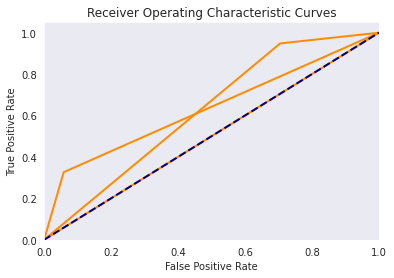

In [ ]:
n_classes = 3

y_train_pred_bin = label_binarize(y_train_svm_pred, classes=[0, 1, 2])

y_bin = label_binarize(y_train, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_train_pred_bin[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')

plot_roc_curve(fpr, tpr)
plt.show()

## RandomForest

In [ ]:
forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
forest_scores

array([0.75636269, 0.75803932, 0.7597969 ])

In [ ]:
forest_scores.mean()

0.7580663029403816

In [ ]:
y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")

In [ ]:
y_train_forest_pred.argmax(axis=1)

array([0, 0, 2, ..., 2, 0, 2])

In [ ]:
confusion_matrix(y_train, y_train_forest_pred.argmax(axis=1))

array([[21165,   750,  3208],
       [ 1611,   932,   604],
       [ 4602,   375, 12840]])

In [ ]:
print(classification_report(y_train, y_train_forest_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81     25123
           1       0.45      0.30      0.36      3147
           2       0.77      0.72      0.75     17817

    accuracy                           0.76     46087
   macro avg       0.67      0.62      0.64     46087
weighted avg       0.75      0.76      0.75     46087



In [ ]:
forest_clf2 = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=0)
accuracy_randomforest2 = cross_val_score(forest_clf2, X_train, y_train, cv=3, scoring="accuracy")
accuracy_randomforest2

array([0.75727397, 0.75934123, 0.7583648 ])

In [ ]:
accuracy_randomforest2.mean()

0.7583266659295681

In [ ]:
y_bin = label_binarize(y_train, classes = [0, 1, 2])

forest_scores2 = cross_val_predict(forest_clf2, X_train, y_train, cv=3, method="predict_proba")

AUC for Class 1: 0.8572994735392424
AUC for Class 2: 0.8372898298539992
AUC for Class 3: 0.8753552749935231


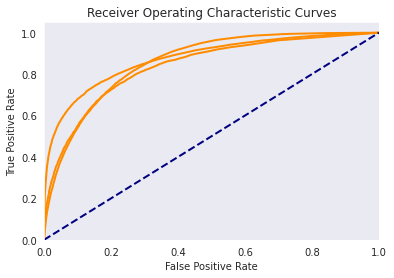

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], forest_scores2[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')

plot_roc_curve(fpr, tpr)
plt.show()


## SGD

In [ ]:
sgd_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=20)

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.65325783, 0.65271449, 0.65531832])

In [ ]:
sgd_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [ ]:
sgd_scores.mean()

0.5276325211013951

In [ ]:
sgd_pred_bin = label_binarize(sgd_scores, classes=[0,1,2])

AUC for Class 1: 0.6531988261713446
AUC for Class 2: 0.5059700842538024
AUC for Class 3: 0.6631414596525192


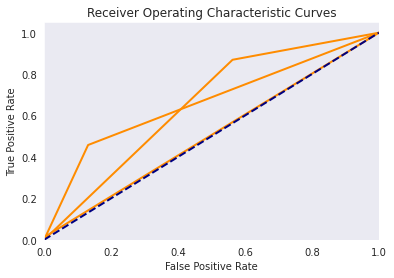

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], sgd_pred_bin[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')

plot_roc_curve(fpr, tpr)
plt.show()


## Logistic Regression

In [ ]:
lreg_clf = LogisticRegression(random_state=0)
cross_val_score(lreg_clf, X_train, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.66959578, 0.66514777, 0.67139695])

In [ ]:
lreg_scores = cross_val_predict(lreg_clf, X_train, y_train, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
lreg_scores.mean()

0.5441013734892703

In [ ]:
lreg_pred_bin = label_binarize(lreg_scores, classes=[0,1,2])

AUC for Class 1: 0.6645531280509357
AUC for Class 2: 0.5005423726606053
AUC for Class 3: 0.6795305479544332


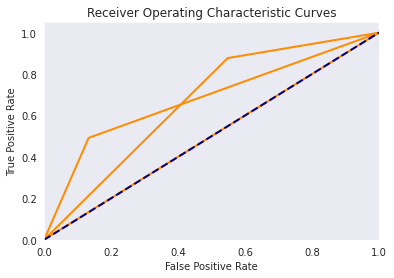

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], lreg_pred_bin[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')

plot_roc_curve(fpr, tpr)
plt.show()